#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

*Целью проекта является подбор такой модели, которая по истории заказов угадывает количество такси на следующий час с ошибкой ≤ 48.*

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Наличие-пропусков" data-toc-modified-id="Наличие-пропусков-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Наличие пропусков</a></span></li></ul></li><li><span><a href="#Анализ-(поиск-закономерностей)" data-toc-modified-id="Анализ-(поиск-закономерностей)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ (поиск закономерностей)</a></span><ul class="toc-item"><li><span><a href="#Динамика-заказов-такси-за-весь-период" data-toc-modified-id="Динамика-заказов-такси-за-весь-период-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Динамика заказов такси за весь период</a></span></li><li><span><a href="#Динамика-заказов-такси-за-весь-период,-ч.2" data-toc-modified-id="Динамика-заказов-такси-за-весь-период,-ч.2-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Динамика заказов такси за весь период, ч.2</a></span></li><li><span><a href="#Динамика-заказов-за-неделю" data-toc-modified-id="Динамика-заказов-за-неделю-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Динамика заказов за неделю</a></span></li><li><span><a href="#Динамика-заказов-такси-за-сутки" data-toc-modified-id="Динамика-заказов-такси-за-сутки-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Динамика заказов такси за сутки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создадим-новые-признаки" data-toc-modified-id="Создадим-новые-признаки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создадим новые признаки</a></span></li><li><span><a href="#Разделение" data-toc-modified-id="Разделение-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование-(проверка-на-тестовой-выборке)-и-проверка-качества-на-тестовой-выборке" data-toc-modified-id="Тестирование-(проверка-на-тестовой-выборке)-и-проверка-качества-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование (проверка на тестовой выборке) и проверка качества на тестовой выборке</a></span><ul class="toc-item"><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>RandomForest</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

**Импорт библиотек**

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import warnings


## Подготовка

In [2]:
df= pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(df.head())
display(df.tail())

#df = df.resample('1H').sum()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Проверка на монотонность

In [4]:
print(df.index.is_monotonic)

True


Данные расположены в хронологическом порядке

In [5]:
df.sort_index(inplace=True)
df = df['2018-03':'2018-09']
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


### Наличие пропусков

In [6]:
print(df.isnull().sum())

num_orders    0
dtype: int64


In [7]:
df.dropna()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [8]:
display(df.info)

<bound method DataFrame.info of                      num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]>

## Анализ (поиск закономерностей)

In [9]:
display(df.describe())

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Динамика заказов такси за весь период

In [10]:
df = df.resample('1H').sum()

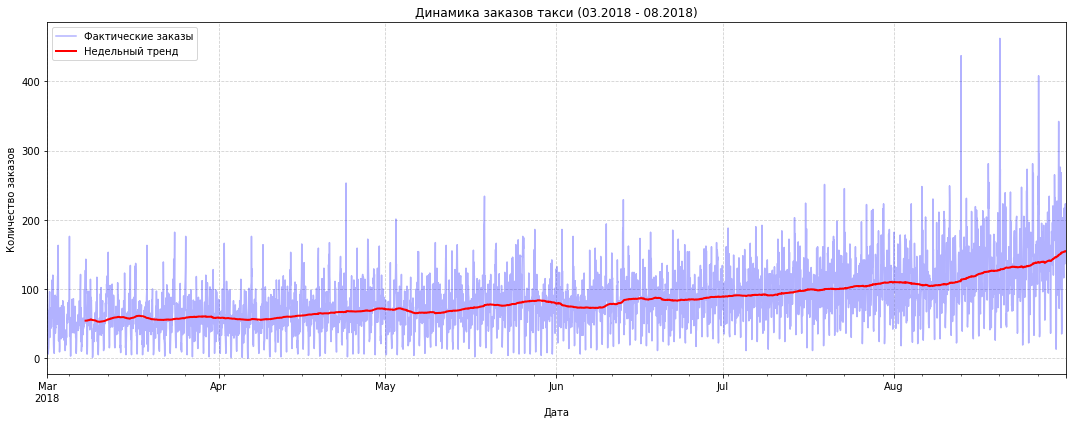

In [11]:
plt.figure(figsize=(15, 6))
df_1=df.copy()

df_1['daily_trend'] =df_1['num_orders'].rolling(168).mean() #в неделе 168 часов

df_1['num_orders'].plot(alpha=0.3, color='blue', label='Фактические заказы')
df_1['daily_trend'].plot(color='red', linewidth=2, label='Недельный тренд')

plt.title('Динамика заказов такси (03.2018 - 08.2018)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**Вывод**
По первому знакомству с датафреймом можно сделать вывод о наличии увеличения количества заказов такси в аэропорт ближе к осени. Также к концу августа наблюдается несколько крупных скачков количества заказов, что может быть связано, в первую очередь, с возвращением обучающихся с каникул (больше 400 заказов), кроме того, эти пики расположен на равном удалении друг от друга, возможно это были выходные дни. 
На основании недельного тренда, который изображен на этом графике, трудно делать какие-то выводы, единственное - действительно наблюдается увеличение количества заказов в связи с изменением сезона.

### Динамика заказов такси за весь период, ч.2

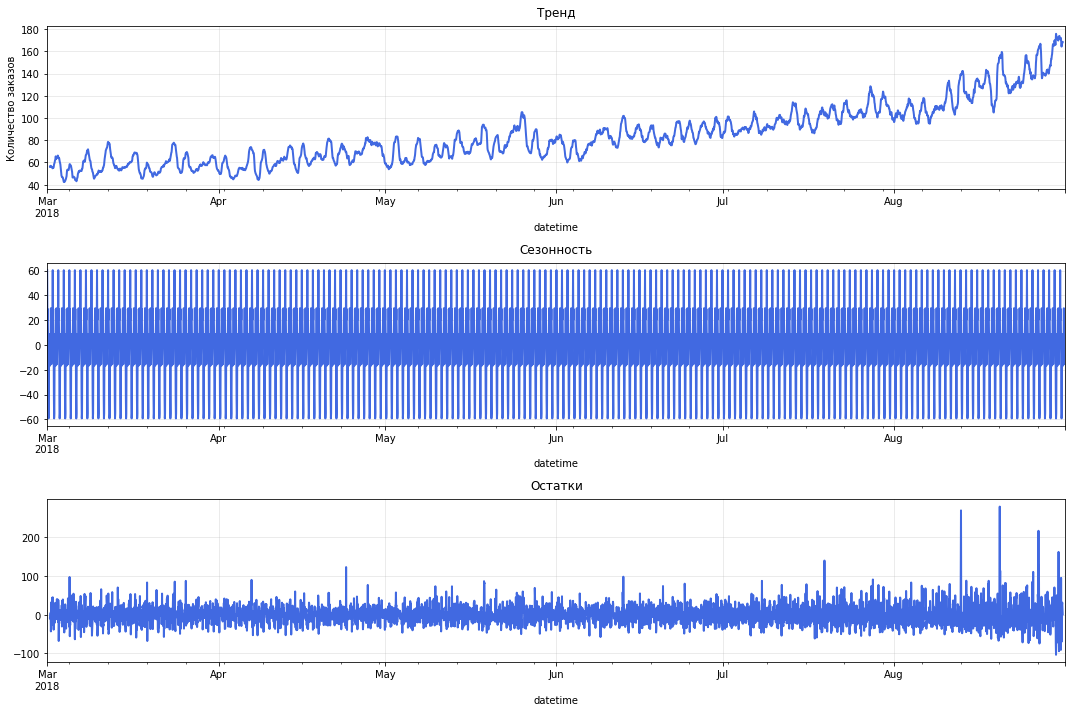

In [12]:
#data = df.resample('1D').sum()

decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 10))


plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), color='royalblue', linewidth=2)
plt.title('Тренд', fontsize=12, pad=10)
plt.ylabel('Количество заказов', fontsize=10)
plt.grid(alpha=0.3)


plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='royalblue', linewidth=2)
plt.title('Сезонность', fontsize=12, pad=10)
plt.grid(alpha=0.3)

# Остатки
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='royalblue', linewidth=2)
plt.title('Остатки', fontsize=12, pad=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

На графике "Тренд" мы уже гораздо лучше видим, что среднее количество заказов увеличивается к сентябрю (возврастающий тренд)

С марта по август количество заказов увеличивается.
Исходя из графика "Сезонность" можем предположить, что на количество заказов зависит от дня недели.

Остатки - это данные, которые нельзя объяснить трендами и сезонностью, в этих данных мы не видим закономерности сейчас, это могут быть праздничные дни, изменение расписания рейсов, либо различные погодные условия.

### Динамика заказов за неделю

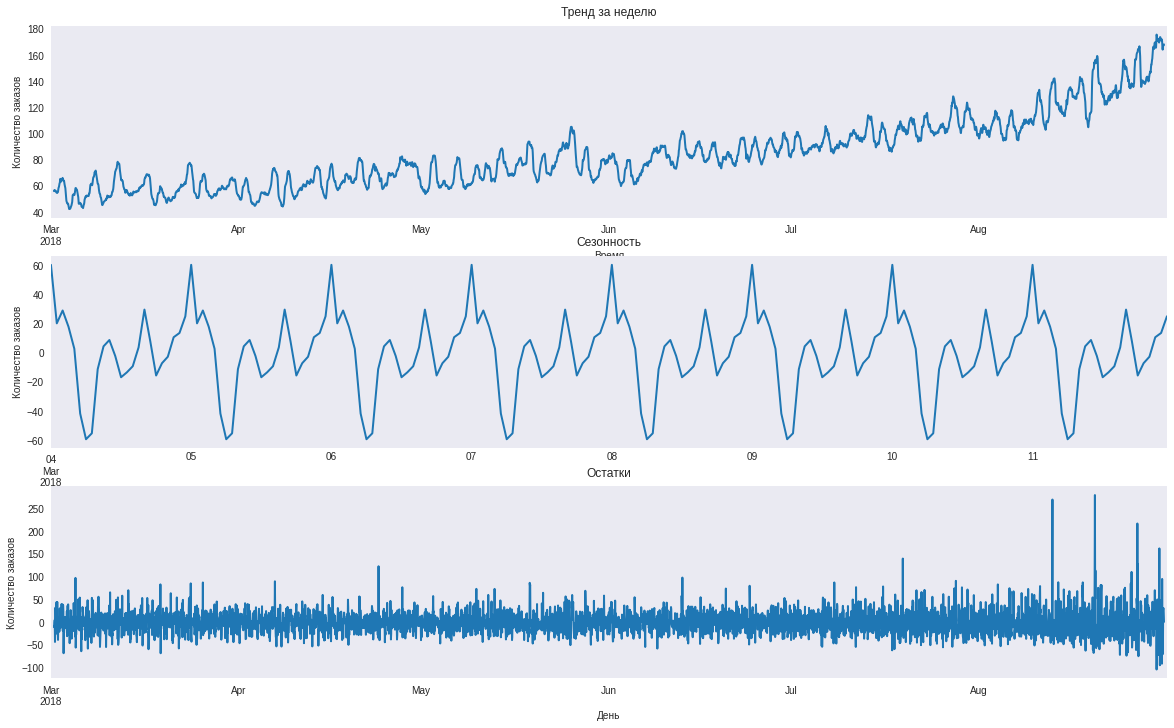

In [13]:
# Выбираем данные за неделю
#week= df['2018-03-04':'2018-03-11']

decomposed_week = seasonal_decompose(df, period=24)  

plt.style.use('seaborn')
colors = ['#1f77b4', '#1f77b4', '#1f77b4']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 12))

# Тренд
decomposed_week.trend.plot(ax=axs[0], color=colors[0], linewidth=2)
axs[0].set_xlabel('Время', fontsize=10)
axs[0].set_ylabel('Количество заказов', fontsize=10)
axs[0].set_title('Тренд за неделю', fontsize=12, pad=10)
axs[0].grid(alpha=0.3)

# Сезонность
decomposed_week.seasonal['2018-03-04':'2018-03-11'].plot(ax=axs[1], color=colors[1], linewidth=2)
axs[1].set_xlabel('Время', fontsize=10)
axs[1].set_ylabel('Количество заказов', fontsize=10)
axs[1].set_title('Cезонность', fontsize=12, pad=10)
axs[1].grid(alpha=0.3)

# Остатки
decomposed_week.resid.plot(ax=axs[2], color=colors[2], linewidth=2)
axs[2].set_xlabel('День', fontsize=10)
axs[2].set_ylabel('Количество заказов', fontsize=10)
axs[2].set_title('Остатки', fontsize=12, pad=10)
axs[2].grid(alpha=0.3)

Середина недели - это более загруженное время.

Чуть расширила период, чтобы график "не обрывался"

### Динамика заказов такси за сутки

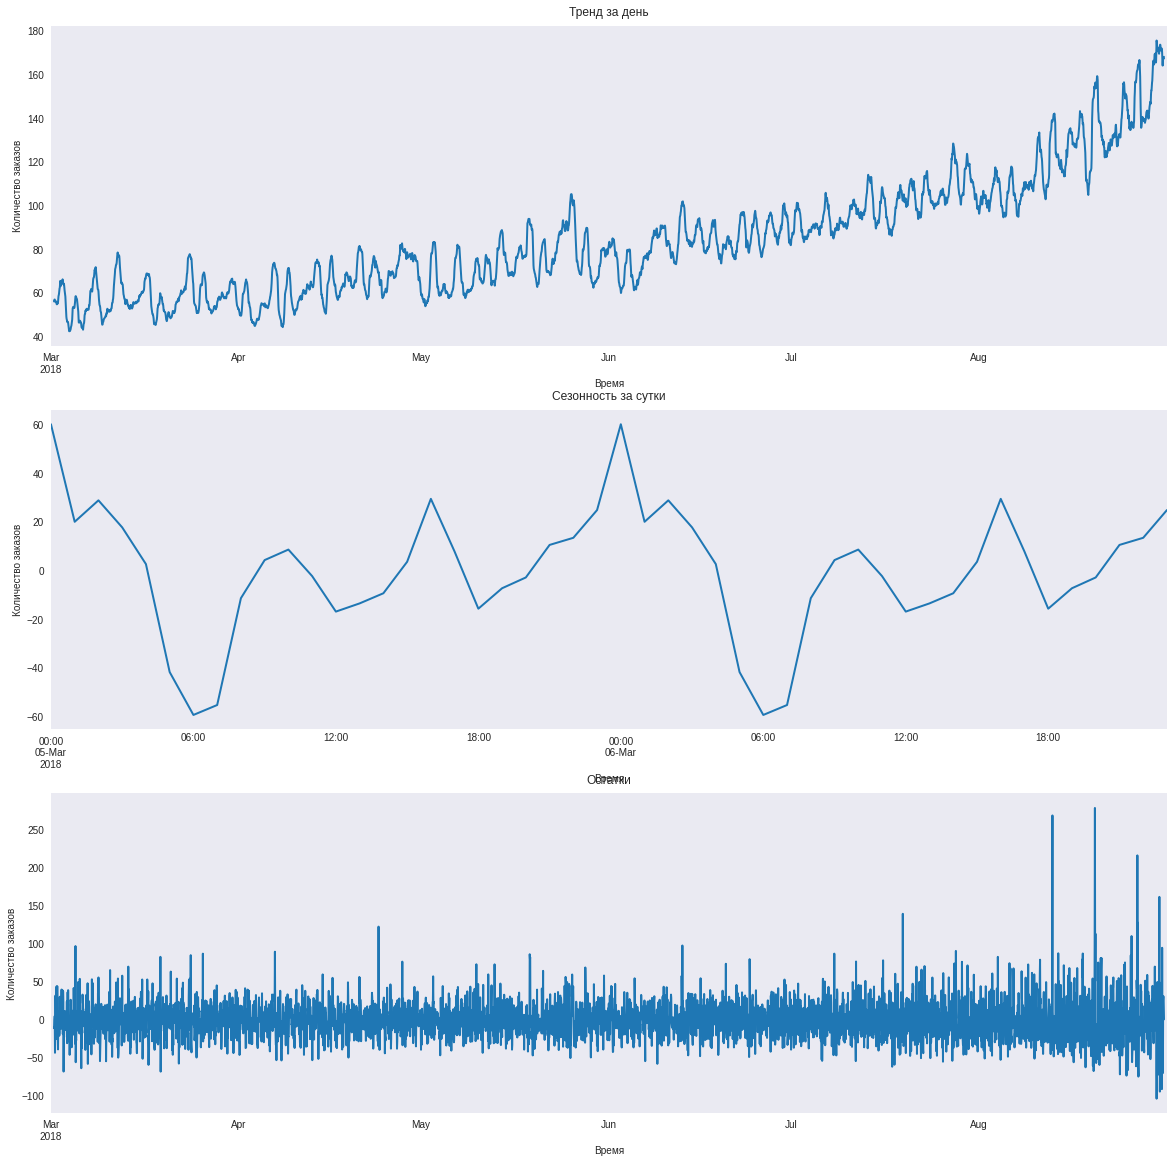

In [14]:
# Выбираем данные за неделю
#oneday = df['2018-03-05': '2018-03-06'].resample('1H').sum()
decomposed_daily = seasonal_decompose(df, period=24)  

plt.style.use('seaborn')
colors = ['#1f77b4', '#1f77b4', '#1f77b4']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))

# Тренд
decomposed_daily.trend.plot(ax=axs[0], color=colors[0], linewidth=2)
axs[0].set_xlabel('Время', fontsize=10)
axs[0].set_ylabel('Количество заказов', fontsize=10)
axs[0].set_title('Тренд за день', fontsize=12, pad=10)
axs[0].grid(alpha=0.3)

# Сезонность
decomposed_daily.seasonal['2018-03-05': '2018-03-06'].plot(ax=axs[1], color=colors[1], linewidth=2)
axs[1].set_xlabel('Время', fontsize=10)
axs[1].set_ylabel('Количество заказов', fontsize=10)
axs[1].set_title('Cезонность за сутки', fontsize=12, pad=10)
axs[1].grid(alpha=0.3)

# Остатки
decomposed_daily.resid.plot(ax=axs[2], color=colors[2], linewidth=2)
axs[2].set_xlabel('Время', fontsize=10)
axs[2].set_ylabel('Количество заказов', fontsize=10)
axs[2].set_title('Остатки', fontsize=12, pad=10)
axs[2].grid(alpha=0.3)

На 5 марта 2018 года как раз пришелся понедельник. Таким образом мы сейчас вывели обычную рабочую неделю и можем оценить измененеие количества заказов.

Наблюдаем, что большое количество заказов выпадает на самый разгар рабочей недели - это среда и четверг. А вот в выходные дни мы видим резкий скачок заказов в воскресенье.

Исследовали 3 сезонности время года (в теплое время года заказов больше), день недели ( в среду и четверг видим резкий рост кол-ва заказов, потом спад и небольшое увеличение в воскресенье, время суток (с 00:00 до 06:00) меньше всего заказов.


Наименьшее количество заказов прихходится на ранее утро (06:00), а пик заказов приходится на середину дня - 12:00.

## Обучение

### Создадим новые признаки

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    df = df.copy()
    # Добавляем временные признаки
    df['month'] = df.index.month
    #df['day'] = df.index.day
    df['hour'] = df.index.hour  #
    df['dayofweek'] = df.index.dayofweek
    df['weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)  # Признак выходного дня
    
    # лаги
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
   
    # скользящее среднее
    df['rolling_mean_24h'] = df['num_orders'].shift().rolling(24).mean() 
    df['rolling_mean_7d'] = df['num_orders'].shift().rolling(168).mean()  
    
    return df


new_df = make_features(df, 24, 168) 

display(new_df.tail())

,num_orders,month,hour,dayofweek,weekend,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_24h,rolling_mean_7d
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,8,19,4,0,207.0,217.0,197.0,116.0,133.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000,154.297619
2018-08-31 20:00:00,154,8,20,4,0,136.0,207.0,217.0,197.0,116.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667,154.434524
2018-08-31 21:00:00,159,8,21,4,0,154.0,136.0,207.0,217.0,197.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667,154.285714
2018-08-31 22:00:00,223,8,22,4,0,159.0,154.0,136.0,207.0,217.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,166.416667,154.244048
2018-08-31 23:00:00,205,8,23,4,0,223.0,159.0,154.0,136.0,207.0,...,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,169.125000,154.130952


### Разделение

In [16]:
train, test = train_test_split(new_df, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.shape)
print(test.shape)

(3806, 31)
(442, 31)


In [17]:
features = ['month', 'dayofweek','hour','weekend'] + [f'lag_{i}' for i in range(1,7)] + ['rolling_mean_24h', 'rolling_mean_7d']

X_train = train[features]
y_train = train['num_orders']
X_test = test[features]
y_test = test['num_orders']

**OHE**

In [18]:
ohe_columns = ['month', 'dayofweek','hour']

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), ohe_columns),
    ],
    remainder='passthrough'
)

### Линейная регрессия

In [19]:
tscv = TimeSeriesSplit(n_splits=5)

In [20]:
RANDOM_STATE = 42


# Полный пайплайн_1
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor), 
    ('scaler', StandardScaler()),   
    ('model', LinearRegression()) 
])


param_distributions = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],  
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}
    

randomized_search = RandomizedSearchCV(
    pipeline_lr, 
    param_distributions, 
    cv=tscv,
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)


randomized_search.fit(X_train, y_train)

# Лучшая модель
best_model = randomized_search.best_estimator_
print("Лучшие параметры:", randomized_search.best_params_)
print("RMSE:", -randomized_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__fit_intercept=False, model__positive=False, scaler=MinMaxScaler(); total time=   0.2s
[CV] END model__fit_intercept=False, model__positive=False, scaler=MinMaxScaler(); total time=   0.3s
[CV] END model__fit_intercept=False, model__positive=False, scaler=MinMaxScaler(); total time=   0.5s
[CV] END model__fit_intercept=False, model__positive=False, scaler=MinMaxScaler(); total time=   0.2s
[CV] END model__fit_intercept=False, model__positive=False, scaler=MinMaxScaler(); total time=   0.3s
[CV] END model__fit_intercept=False, model__positive=False, scaler=StandardScaler(); total time=   0.2s
[CV] END model__fit_intercept=False, model__positive=False, scaler=StandardScaler(); total time=   0.4s
[CV] END model__fit_intercept=False, model__positive=False, scaler=StandardScaler(); total time=   0.2s
[CV] END model__fit_intercept=False, model__positive=False, scaler=StandardScaler(); total time=   0.4s
[CV] END mode

Лучшие параметры: {'scaler': None, 'model__positive': False, 'model__fit_intercept': True}

**RMSE: 25.331 < 48**

### RandomForest

In [21]:
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42


pipeline_rf = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', RandomForestRegressor(random_state=RANDOM_STATE)) 
])

param_distributions_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

randomized_search_rf = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_distributions_rf,
    n_iter=10,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)

# обучение
randomized_search_rf.fit(X_train, y_train)

best_model_rf = randomized_search_rf.best_estimator_
print("Лучшие параметры:", randomized_search_rf.best_params_)
print("RMSE:", -randomized_search_rf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   2.8s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   4.6s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   6.1s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   8.1s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   8.9s
[CV] END model__max_depth=5, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   1.8s
[CV] END model__max_depth=5, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   1.2s
[CV] END model__max_depth=5, model__mi

Лучшие параметры: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': 20}


**RMSE: 25.296< 48**

### LightGBM

In [22]:
from lightgbm import LGBMRegressor 
pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', LGBMRegressor())
])

param_grid_lgbm = [
    {
        'model': [LGBMRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [50, 100],
        'model__max_depth': [5, 7],
        'model__learning_rate': [0.1, 0.05]
    }    
]

randomized_search_lgbm = RandomizedSearchCV(
    pipeline_lgbm,
    param_grid_lgbm,
    n_iter=5,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)

# обучение
randomized_search_lgbm.fit(X_train, y_train)

best_model_lgbm = randomized_search_lgbm.best_estimator_
print("Лучшие параметры:", randomized_search_lgbm.best_params_)
print("RMSE:", -randomized_search_lgbm.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END model=LGBMRegressor(random_state=42), model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100; total time=  55.1s
[CV] END model=LGBMRegressor(random_state=42), model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100; total time= 1.7min
[CV] END model=LGBMRegressor(random_state=42), model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100; total time= 2.2min
[CV] END model=LGBMRegressor(random_state=42), model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100; total time= 2.0min
[CV] END model=LGBMRegressor(random_state=42), model__learning_rate=0.1, model__max_depth=5, model__n_estimators=100; total time= 1.7min
[CV] END model=LGBMRegressor(random_state=42), model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100; total time=  60.0s
[CV] END model=LGBMRegressor(random_state=42), model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100

Лучшие параметры: {'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.05, 'model': LGBMRegressor(learning_rate=0.05, max_depth=7, random_state=42)}

**RMSE: 25.840 < 48**

## Тестирование (проверка на тестовой выборке) и проверка качества на тестовой выборке

Все рассмотренные модели показали себя хорошо, RMSE< 48.
Самый лучший результат достигнут на модели RandomForest, RMSE = 22.52.

### RandomForest

In [23]:
best_model_rf = randomized_search_rf.best_estimator_
y_test_rf = best_model_rf.predict(X_test)

print("RMSE на тесте:", mean_squared_error(y_test,y_test_rf, squared=False))

RMSE на тесте: 41.44566798315139


RMSE на тесте: 41.44< 48.
В целом, предложенная модель соответствует пожеланиям заказчика.

## Вывод

В рамках данного проекта мы познакомились с принципами работы с временными данными.
Целью данного проекта являлось научиться предсказывать количество заказов такси в аэропорт на час вперед. Для этого необходимо было загрузить и проанализировать данные, посмотреть, что влияет на спрос заказа такси в аэропорт (другими словами - изучить закономерности), а далее обучить несколько моделей на временных данных, которые смогут наиболее хорошо предсказывать будущий спрос на такси в аэропорт, и получить значение RMSE на тестовой выборке не более 48.

Наилучший результат (по метрике RMSE) достигнут на тренировочных данных при применении модели RandomForest.
На тестовых данных модель показала себя хуже, но все равно в требуемые значения результат попадает.